In [1]:
import gzip
import random
import os
import numpy as np
import itertools
from collections import Counter, defaultdict
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('classic')

In [2]:
style = ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

In [80]:
alphabet_dna = ['A','C','G','T']

In [4]:
def is_header(line):
    """Check if the line starts with '>'."""
    return line[0] == '>'


def parse_fasta_file(filename):
    """It reads and returns a name and the sequence from a file (compressed or not)."""
    if filename.endswith('.gz'):
        opener = lambda filename: gzip.open(filename, 'rt')
    else:
        opener = lambda filename: open(filename, 'r')

    with opener(filename) as f:
        fasta_iter = (it[1] for it in itertools.groupby(f, is_header))
        for name in fasta_iter:
            name = name.__next__()[1:].strip()
            sequences = ''.join(seq.strip() for seq in fasta_iter.__next__())
            yield name, sequences

In [5]:
def nuc_count(sequence, alphabet):
    sequence = sequence.upper()
    return {base: sequence.count(base) for base in sequence if base in alphabet}

In [6]:
def alternative_bases_counter(sequence):
    seq = sequence.upper()
    counter = defaultdict(int)
    alternative = ['R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V', 'N']
    for base in seq:
        if base in alternative:
            counter[base] += 1
        else:
            counter[base] += 0
    return counter

In [7]:
def nuc_frequency(sequence, alphabet):
    ns = alternative_bases_counter(sequence)
    l_seq = len(sequence) - sum(ns.values())
    counts = nuc_count(sequence, alphabet)
    return {base: (value / l_seq) for base, value in counts.items()}

In [8]:
def get_gc_content(sequence):
    """Returns the gc content of a genome."""
    len_seq = len(sequence) - sum(alternative_bases_counter(sequence).values())
    sequence = sequence.upper()
    c = sequence.count('C')
    g = sequence.count('G')
    return round((c + g) / len_seq, 4)

In [9]:
def get_at_content(sequence):
    """Returns the at content of a genome."""
    return 1 - get_gc_content(sequence)

In [10]:
def get_at_gc_ratio(sequence):
    """Returns the at/gc ratio of a genome."""
    return get_at_content(sequence) / get_gc_content(sequence)

In [11]:
def get_strand_complement(sequence):
    """Returns the complement strand of the genome."""
    seq = sequence.upper()
    change = str.maketrans('ACGT', 'TGCA')
    return seq.translate(change)

In [12]:
def get_reverse_complement(sequence):
    """Returns the reverse complement strand of the genome."""
    seq = sequence.upper()
    return get_strand_complement(seq)[::-1]

In [26]:
def create_random_sequence( alphabet, nuc_freqs, n):
    return ''.join(np.random.choice(alphabet, p=nuc_freqs) for _ in range(n))

In [27]:
seq1 = create_random_sequence(alphabet_dna, [0.25, 0.25, 0.25, 0.25], 565)

In [13]:
def kmer_count(sequence, alphabet, k=1):
    seq = sequence.upper()
    seq_len = len(seq)
    kmers =  [seq[i:i+k] for i in range(0, seq_len - k + 1)]
    filterd_kmers = [kmer for kmer in kmers if all(base in set(alphabet) for base in kmer)]
    return Counter(filterd_kmers)

In [14]:
def print_kmers_stats(sequence, alphabet, start, k):
    seq = sequence.upper()
    print('  k     k-mers              4^k      N-k+1          missing   repeated')
    for k in range(start, k):
        kmers = kmer_count(seq, alphabet, k)
        print("%3d %10d %16d %10d %16d %10d" % (k, 
                                                len(kmers), 
                                                4**k, 
                                                (len(seq)-1)-k+1, 
                                                4**k-len(kmers), 
                                                (len(seq)-1)-k+1-len(kmers)))
    return

In [ ]:
print_kmers_stats(seq, alphabet_dna, 3, 25)

In [ ]:
dict_kmer = kmer_count(seq, alphabet_dna, 10)
seq_len = len(seq)

In [15]:
def kmers_frequency(kmers_dict):
    num_kmers = len(kmers_dict.keys())
    kmer_freq = defaultdict(float)
    for kmer, count in kmers_dict.items():
        kmer_freq[kmer] = (count / num_kmers)
    return kmer_freq    

In [16]:
def kmer_positions(sequence, k):
    """ returns the position of all k-mers in sequence as a dictionary"""
    seq = sequence.upper()
    kmer_position = {}
    for i in range(1, len(seq) - k + 1):
        kmer = seq[i:i+k]
        kmer_position[kmer] = kmer_position.get(kmer,[]) + [i]
    # combine kmers with their reverse complements
    pair_position = {}
    for kmer, pos_lst in kmer_position.items():
        krev = get_reverse_complement(kmer)
        if (kmer < krev):
            pair_position[kmer] = sorted(pos_lst + kmer_position.get(krev, []))
        elif (krev < kmer):
            pair_position[krev] = sorted(kmer_position.get(krev, []) + pos_lst)
        else:
            pair_position[kmer] = pos_lst
    return pair_position

In [17]:
def kmers_clumps(sequence, k, w, t):
    """ Find clumps of repeated k-mers in string. A clump occurs when t or more k-mers appear 
        within a window of size w. A list of (k-mer, position, count) tuples is returned 
        clumpList = kmers_clumps(seq, 9, 500, 6)
        print(len(clumpList))
        print([clumpList[i] for i in range(min(20,len(clumpList)))])
    """
    seq = sequence.upper()
    clumps = []
    kmers = kmer_positions(seq, k)
    for kmer, pos in kmers.items():
        for start in range(len(pos) - t):
            end = start + t - 1
            while ((pos[end] - pos[start]) <= w - k):
                end += 1
                if (end >= len(pos)):
                    break
            if (end - start >= t):
                clumps.append((kmer, pos[start], end - start))
    return clumps

In [18]:
def check_is_palindrome(sequence, kmer):
    """Returns True if the sequence is palindromic other wise
    False."""
    seq = sequence.upper()
    kmer = kmer.upper()
    return seq.find(kmer[::-1]) == 0

In [19]:
def get_palindromes(sequence, alphabet, k):
    """Returns the count of all the palindromic
    substrings of a genome."""
    kmers = list(kmer_count(sequence, alphabet, k).keys())
    rev_kmers = [get_reverse_complement(kmer) for kmer in kmers]
    palindromes = set()
    for mer1, mer2 in zip(kmers, rev_kmers):
        if mer1 == mer2:
            palindromes.add((mer1, mer2))
    return palindromes

In [20]:
def get_chunks(sequence, window_size, step=1):
    """Returns a chunk of length of window_size and the end of the window size"""
    k = len(sequence)
    for i in range(0, k - window_size + 1, step):
        end = i + window_size
        chunk = sequence[i:i + window_size]
        assert len(chunk) == window_size
        yield chunk, end

In [21]:
def gc_skew(sequence):
    """Finds the genome GC skew."""
    seq = sequence.upper()
    half = len(sequence) // 2
    genome = np.frombuffer(seq.encode() + seq.encode(), dtype='uint8')
    g = np.concatenate(([0], np.array(genome == ord('G'), dtype='uint8').cumsum()))
    c = np.concatenate(([0], np.array(genome == ord('C'), dtype='uint8').cumsum()))
    gc = g - c
    skew = gc[half:(half + len(sequence))] - gc[0:len(sequence)] + \
           gc[(len(sequence) - half):(2 * len(sequence) - half)] - gc[len(sequence):(2 * len(sequence))]
    return skew

In [22]:
def get_multinomial_model(sequence, alphabet):
    """Returns a simple multinomial probabilistic model"""
    return nuc_frequency(sequence, alphabet)

In [23]:
def get_markov_model(sequence):
    """Returns a simple Markov model"""
    alphabet = set(sequence.upper())
    mkm = dict()
    for i, base in enumerate(alphabet):
        intervals = sorted([0] + [random.random() for _ in range(3)] + [1])
        probs = [intervals[i+1] - intervals[i] for i in range(4)]
        mkm[base] = {base: prob for base, prob in zip(alphabet, probs)}
    return mkm

In [24]:
def get_top_n_kmers(sequence, k):
    kmers = kmer_positions(seq, k)
    # find kmers appearing in the most clumps
    mer_clump = {}
    for kmer, start, clumpSize in clumpList:
        mer_clump[kmer] = mer_clump.get(kmer,0) + 1
    top10 = [k for k in sorted(mer_clump, reverse=True, key=mer_clump.get)][:9]
    return top10

In [74]:
def plot_kmer_frequencies(start, kmers, top_10_kmers):
    plt.figure(num=None, figsize=(16, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.plot([start, start], [0,10], 'r--')
    for n, kmer in enumerate(top_10_kmers):
        positions = kmers[kmer]
        plt.text(1120000, n + 0.4, kmer, fontsize=10)
        plt.plot(positions, [n + 0.5 for i in range(len(positions))], 'o', markersize=4.0)
    limit = plt.xlim((0,1200000))
    plt.title('Most frequent k-mers')
    plt.xlabel('Sequence length')
    plt.ylabel('Number sequences')
    plt.tight_layout()

In [ ]:
def get_bases_stats(sequence, alphabet, start):
    """Returns the base statistics from diferent strands of a bacterial chromossome.
    It shows the difference in C e G composition in the lagg and lead strand"""
    seq = sequence.upper()
    seq_len = len(seq)
    half_seq = seq_len // 2
    ter = start + half_seq
    # as a circular genome
    if ter > seq_len:
        ter = ter - seq_len + 1
    counts = defaultdict(int)
    for base in alphabet:
        total = seq.count(base)
        if ter > start:  # start ---> ter
            f_count = seq[start:ter].count(base)
            r_count = total - f_count
        else:  # ter ---> start
            r_count = seq[ter:start].count(base)
            f_count = total - r_count
        counts[base] = (total, f_count, r_count)
    return counts
            

In [ ]:
def print_strand_stats(sequence, alphabet, start):
    strands = get_bases_stats(sequence, start)
    for base in alphabet_dna:
        total, f_count, r_count = strands[base]
        print(f'{base}:\t{total}\t{f_count}\t{r_count}\t{f_count-r_count}')
    return 

In [ ]:
def get_gc_strand_difference(sequence, start):
    seq = sequence.upper()
    seq_len = len(seq)
    half = seq_len // 2
    ter = start + half
    if ter > seq_len:
        ter = ter - seq_len + 1
    elif ter > star:
        g = 2 * seq[start:ter].count('G') - seq.count('G')
        c = 2 * seq[start:ter].count('C') - seq.count('C')
    else:
        g = seq.count('G') - 2 * seq[start:ter].count('G')
        c = seq.count('C') - 2 * seq[start:ter].count('C')
    return g - c       

In [ ]:
def GC_skew(sequence, n):
    x = []
    y = []
    for i in range(len(sequence), n):
        x.append(i)
        y.append(get_gc_strand_difference(sequence, i))
    return x, y

In [ ]:
def plot_gc_skew(x, y):
    """Returns a plot of the genome gc skew
    input: GC_skew(sequence, n)"""
    plt.figure(num=None, figsize=(24, 7), dpi=100)
    yargmax = y.index(max(y))
    plt.axvline(oriCStart+oriOffset, color="r", linestyle='--')
    plt.axvline(x[yargmax], color="g", linestyle='--')
    result = plt.plot(x, y)
    print(x[yargmax], y[yargmax])

In [28]:
!ls Data

colera_v.fasta	CP000626.fasta	NC_008457_1.fasta  termo_pet.fasta


In [29]:
filename = 'Data/colera_v.fasta'

for name, seq in parse_fasta_file(filename):
     clumpList = kmers_clumps(seq, 9, 500, 6)
print(len(clumpList))
print([clumpList[i] for i in range(min(20,len(clumpList)))])

172
[('ATCAAAAAT', 566251, 6), ('AACCAGAAC', 922081, 13), ('AACCAGAAC', 922087, 12), ('AACCAGAAC', 922093, 11), ('AACCAGAAC', 922099, 10), ('AACCAGAAC', 922105, 9), ('AACCAGAAC', 922111, 8), ('AACCAGAAC', 922117, 7), ('AACCAGAAC', 922123, 6), ('GCAATAACA', 704433, 6), ('ATGTTATTG', 704432, 6), ('AATAACATC', 704431, 6), ('CTCTCTCTC', 798534, 6), ('AAATCAAAA', 566246, 7), ('AAATCAAAA', 566253, 6), ('AACAGCAAC', 1073066, 21), ('AACAGCAAC', 1073072, 20), ('AACAGCAAC', 1073078, 19), ('AACAGCAAC', 1073084, 18), ('AACAGCAAC', 1073090, 17)]


In [30]:
print_kmers_stats(seq, alphabet_dna, 3, 25)

  k     k-mers              4^k      N-k+1          missing   repeated
  3         64               64    1108247                0    1108183
  4        256              256    1108246                0    1107990
  5       1024             1024    1108245                0    1107221
  6       4096             4096    1108244                0    1104148
  7      16382            16384    1108243                2    1091861
  8      65099            65536    1108242              437    1043143
  9     234316           262144    1108241            27828     873925
 10     571913          1048576    1108240           476663     536327
 11     870755          4194304    1108239          3323549     237484
 12    1009883         16777216    1108238         15767333      98355
 13    1056503         67108864    1108237         66052361      51734
 14    1070862        268435456    1108236        267364594      37374
 15    1075606       1073741824    1108235       1072666218      32629
 16   

In [38]:
!ls Data

colera_v.fasta	CP000626.fasta	NC_008457_1.fasta  termo_pet.fasta


In [35]:
filename2 = 'Data/NC_008457_1.fasta'
for name, chr1 in parse_fasta_file(filename2):
    genome = chr1

In [41]:
oriC = 'atcaatgatcaacgtaagcttctaagcatgatcaaggtgctcacacagtttatccacaac\
    ctgagtggatgacatcaagataggtcgttgtatctccttcctctcgtactctcatgacca\
    cggaaagatgatcaagagaggatgatttcttggccatatcgcaatgaatacttgtgactt\
    gtgcttccaattgacatcttcagcgccatattgcgctggccaaggtgacggagcgggatt\
    acgaaagcatgatcatggctgttgttctgtttatcttgttttgactgagacttgttagga\
    tagacggtttttcatcactgactagccaaagccttactctgcctgacatcgaccgtaaat\
    tgataatgaatttacatgcttccgcgacgatttacctcttgatcatcgatccgattgaag\
    atcttcaattgttaattctcttgcctcgactcatagccatgatgagctcttgatcatgtt\
    tccttaaccctctattttttacggaagaatgatcaagctgctgctcttgatcatcgtttc'

In [47]:
for i in range(1, 10):
    most_commom = kmer_count(oriC, alphabet_dna, i).most_common(6)
    print(i, most_commom, '\n')

1 [('T', 174), ('A', 136), ('C', 122), ('G', 108)] 

2 [('AT', 53), ('TT', 53), ('TC', 48), ('TG', 46), ('GA', 46), ('CT', 44)] 

3 [('TGA', 25), ('ATC', 21), ('GAT', 19), ('TCA', 17), ('CTT', 17), ('TCT', 16)] 

4 [('ATGA', 12), ('ATCA', 11), ('TGAT', 11), ('GATC', 9), ('TGAC', 8), ('CTCT', 8)] 

5 [('TGATC', 8), ('GATCA', 8), ('ATGAT', 7), ('ATCAA', 6), ('TCTTG', 6), ('AATGA', 4)] 

6 [('TGATCA', 8), ('ATGATC', 5), ('GATCAA', 4), ('ATCAAG', 4), ('GATCAT', 4), ('CTCTTG', 4)] 

7 [('ATGATCA', 5), ('TGATCAA', 4), ('TGATCAT', 4), ('GATCAAG', 3), ('TGACATC', 3), ('CTCTTGA', 3)] 

8 [('ATGATCAA', 4), ('TGATCAAG', 3), ('CTCTTGAT', 3), ('TCTTGATC', 3), ('CTTGATCA', 3), ('TTGATCAT', 3)] 

9 [('ATGATCAAG', 3), ('CTCTTGATC', 3), ('TCTTGATCA', 3), ('CTTGATCAT', 3), ('AATGATCAA', 2), ('AAGCATGAT', 2)] 



In [49]:
ter_oriC = 'aactctatacctcctttttgtcgaatttgtgtgatttatagagaaaatcttattaactgaaac\
taaaatggtaggtttggtggtaggttttgtgtacattttgtagtatctgatttttaattacat\
accgtatattgtattaaattgacgaacaattgcatggaattgaatatatgcaaaacaaaccta\
ccaccaaactctgtattgaccattttaggacaacttcagggtggtaggtttctgaagctctca\
tcaatagactattttagtctttacaaacaatattaccgttcagattcaagattctacaacgct\
gttttaatgggcgttgcagaaaacttaccacctaaaatccagtatccaagccgatttcagaga\
aacctaccacttacctaccacttacctaccacccgggtggtaagttgcagacattattaaaaa\
cctcatcagaagcttgttcaaaaatttcaatactcgaaacctaccacctgcgtcccctattat\
ttactactactaataatagcagtataattgatctgaaaagaggtggtaaaaaa'
    
for i in range(1, 10):
    most_commom = kmer_count(ter_oriC, alphabet_dna, i).most_common(6)
    print(i, most_commom, '\n')

1 [('A', 185), ('T', 178), ('C', 108), ('G', 86)] 

2 [('AA', 67), ('TT', 64), ('TA', 57), ('AT', 47), ('AC', 44), ('CT', 36)] 

3 [('AAA', 29), ('TTT', 24), ('ATT', 24), ('ACC', 20), ('TAC', 19), ('TTA', 18)] 

4 [('AAAA', 13), ('TACC', 11), ('ACCT', 9), ('TTTT', 9), ('ATTT', 9), ('TATT', 9)] 

5 [('ACCTA', 6), ('TACCA', 6), ('ACCAC', 6), ('TATTA', 5), ('TGGTA', 5), ('CCTAC', 5)] 

6 [('TACCAC', 6), ('ACCTAC', 5), ('CCTACC', 5), ('CTACCA', 5), ('GGTGGT', 4), ('GTGGTA', 4)] 

7 [('ACCTACC', 5), ('CCTACCA', 5), ('CTACCAC', 5), ('GGTGGTA', 4), ('TACCACC', 4), ('TGGTAGG', 3)] 

8 [('ACCTACCA', 5), ('CCTACCAC', 5), ('TGGTAGGT', 3), ('GGTAGGTT', 3), ('GTAGGTTT', 3), ('AAACCTAC', 3)] 

9 [('ACCTACCAC', 5), ('TGGTAGGTT', 3), ('GGTAGGTTT', 3), ('AAACCTACC', 3), ('AACCTACCA', 3), ('CCTACCACC', 3)] 



In [54]:
clumpList = kmers_clumps(seq, 9, 500, 6)
print(len(clumpList))
print([clumpList[i] for i in range(min(20,len(clumpList)))])

172
[('ATCAAAAAT', 566251, 6), ('AACCAGAAC', 922081, 13), ('AACCAGAAC', 922087, 12), ('AACCAGAAC', 922093, 11), ('AACCAGAAC', 922099, 10), ('AACCAGAAC', 922105, 9), ('AACCAGAAC', 922111, 8), ('AACCAGAAC', 922117, 7), ('AACCAGAAC', 922123, 6), ('GCAATAACA', 704433, 6), ('ATGTTATTG', 704432, 6), ('AATAACATC', 704431, 6), ('CTCTCTCTC', 798534, 6), ('AAATCAAAA', 566246, 7), ('AAATCAAAA', 566253, 6), ('AACAGCAAC', 1073066, 21), ('AACAGCAAC', 1073072, 20), ('AACAGCAAC', 1073078, 19), ('AACAGCAAC', 1073084, 18), ('AACAGCAAC', 1073090, 17)]


In [55]:
top = get_top_n_kmers(seq, 9)

In [62]:
kmers = kmer_positions(seq, 9)

In [58]:
oric_start = seq.find('ATCAATGATCAACGTAAGCTTCTAAGCATGATCAAGGTGCTCACACAG')
oric_start

151886

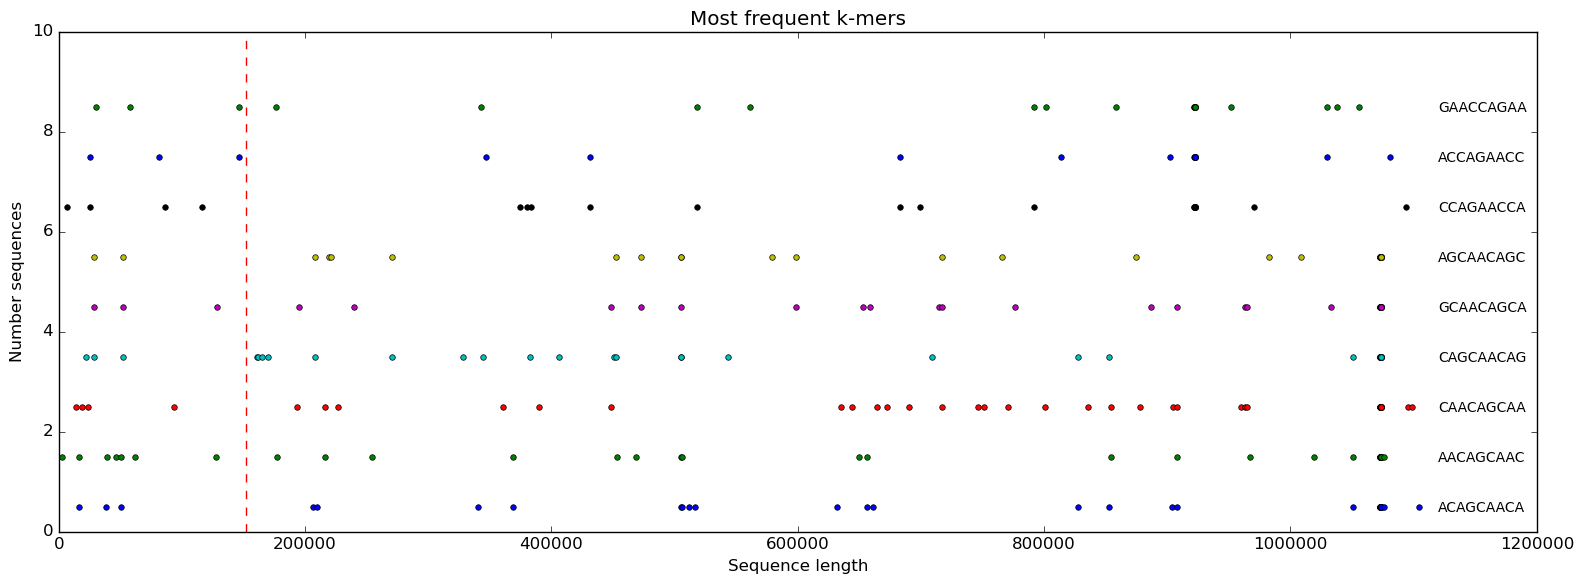

In [76]:
plot_kmer_frequencies(oric_start + 1, kmers, top)
plt.savefig('clumps_freq_kmers.pdf', format='pdf', dpi=1200)
plt.show()

In [77]:
filename2 = 'Data/termo_pet.fasta'
for name, ter_seq in parse_fasta_file(filename2):
    genome_ter = ter_seq

In [ ]:
print(nuc_count(genome_ter, alphabet_dna))

In [ ]:
ter_oriC_start = 786686
oriOffset = 211          # offset to the middle of OriC
start = (ter_oric_start + oriOffset)